<a href="https://colab.research.google.com/github/asasinater1234/mAId/blob/main/Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Installing Libraries

!pip install -q roboflow timm albumentations scikit-learn pyyaml tqdm torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.6 MB/s eta 0:00:00


In [ ]:
# CELL 2: Mount workspace onto google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#CELL 3: Download Dataset from Roboflow API Key

from roboflow import Roboflow
rf = Roboflow(api_key="B2175hBeuaIyZtcrZEr7")
project = rf.workspace("sutd-vicns").project("for-a_stage1_2")
version = project.version(1)
dataset = version.download(
    "folder",
    location="/content/drive/MyDrive/Unmake"
)

print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/drive/MyDrive/Unmake in folder:: 100%|██████████| 511/511 [00:05<00:00, 90.38it/s]

Dataset downloaded to: /content/drive/MyDrive/Unmake


In [ ]:
#CELL 4: Roboflow format to CSV format

import os
import shutil
import pandas as pd


roboflow_root = dataset.location
output_root = "/content/drive/MyDrive/Unmade"

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_root, "images", split), exist_ok=True)

def convert_split(split_name, label_map={"Made": 0, "Unmade": 1}):
    rows = []

    target_split = "val" if split_name == "valid" else split_name
    dst_dir = os.path.join(output_root, "images", target_split)

    for class_name, label in label_map.items():
        src_dir = os.path.join(roboflow_root, split_name, class_name)

        if not os.path.exists(src_dir):
            print(f"Warning: {src_dir} not found, skipping...")
            continue

        img_files = [
            f for f in os.listdir(src_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        for img_file in img_files:
            shutil.copy2(
                os.path.join(src_dir, img_file),
                os.path.join(dst_dir, img_file)
            )
            rows.append({"image_id": img_file, "label": label})

        print(f"  {class_name}: {len(img_files)} images")

    df = pd.DataFrame(rows)
    csv_name = f"{target_split}.csv"
    df.to_csv(os.path.join(output_root, csv_name), index=False)

    print(f"Created {csv_name} with {len(df)} images\n")
    return df


print("Converting train split...")
train_df = convert_split("train")

print("Converting valid split...")
val_df = convert_split("valid")

print("Converting test split...")
test_df = convert_split("test")

print("\nDataset Summary:")
print(f"  Train: {len(train_df)} images")
print(f"  Val:   {len(val_df)} images")
print(f"  Test:  {len(test_df)} images")


Converting train split...
  Made: 180 images
  Unmade: 169 images
Created train.csv with 349 images

Converting valid split...
  Made: 46 images
  Unmade: 55 images
Created val.csv with 101 images

Converting test split...
  Made: 24 images
  Unmade: 26 images
Created test.csv with 50 images


Dataset Summary:
  Train: 349 images
  Val:   101 images
  Test:  50 images


In [ ]:
#CELL 5: Create Common utilities:

import os

PROJECT_ROOT = "/content/drive/MyDrive/projects"

dirs = [
    "src/common",
    "src/stage1_binary",
    "configs",
    "runs/stage1_binary",
    "data",
    "submissions"
]

for d in dirs:
    os.makedirs(os.path.join(PROJECT_ROOT, d), exist_ok=True)

%cd /content/drive/MyDrive/projects


/content/drive/MyDrive/projects


In [ ]:
# CELL 6: Create Common Utilities - seed.py

%%writefile src/common/seed.py
import os
import random
import numpy as np
import torch

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Writing src/common/seed.py


In [ ]:
# CELL 7: Create Common Utilities - io.py

%%writefile src/common/io.py
from __future__ import annotations
import os
import json
from typing import Dict, Any, List
import pandas as pd

def read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV not found: {path}")
    return pd.read_csv(path)

def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def write_csv(df: pd.DataFrame, path: str) -> None:
    ensure_dir(os.path.dirname(path) or ".")
    df.to_csv(path, index=False)

def write_json(obj: Dict[str, Any], path: str) -> None:
    ensure_dir(os.path.dirname(path) or ".")
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def list_images_from_dir(img_dir: str, suffix: str = ".jpg") -> List[str]:
    if not os.path.isdir(img_dir):
        raise NotADirectoryError(f"Image directory not found: {img_dir}")
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(suffix)]
    files.sort()
    return files

Overwriting src/common/io.py


In [ ]:
# CELL 8: Create Common Utilities - utils.py

%%writefile src/common/utils.py
from __future__ import annotations
import time
import torch

class Timer:
    def __init__(self):
        self.t0 = time.time()

    def reset(self):
        self.t0 = time.time()

    def elapsed(self) -> float:
        return time.time() - self.t0

def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

Writing src/common/utils.py


In [ ]:
# CELL 9: Create Common Utilities - metrics.py

%%writefile src/common/metrics.py
from __future__ import annotations
from typing import Tuple
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

def compute_binary_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """
    Returns: (macro_f1, accuracy)
    """
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    acc = float(accuracy_score(y_true, y_pred))
    return macro_f1, acc

def compute_multilabel_metrics(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    thresholds=None
):
    """
    Returns dict with:
      map: mean average precision across labels
      macro_f1: macro F1 across labels (computed after thresholding probs)
      per_label_ap: list of AP per label
    """
    K = y_true.shape[1]
    per_ap = []
    for k in range(K):
        ap = average_precision_score(y_true[:, k], y_prob[:, k])
        per_ap.append(float(ap))
    mAP = float(np.mean(per_ap))

    if thresholds is None:
        thresholds = np.array([0.5] * K, dtype=np.float32)
    else:
        thresholds = np.array(thresholds, dtype=np.float32)

    y_pred = (y_prob >= thresholds[None, :]).astype(np.int32)
    macro_f1 = float(f1_score(y_true, y_pred, average="macro", zero_division=0))

    return {"map": mAP, "macro_f1": macro_f1, "per_label_ap": per_ap}

Writing src/common/metrics.py


In [ ]:
# CELL 10: Create Common Utilities - transforms.py

%%writefile src/common/transforms.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Tuple
import albumentations as A
from albumentations.pytorch import ToTensorV2

@dataclass
class TransformSpec:
    img_size: int = 224

def get_train_transforms(preset: str, img_size: int) -> A.Compose:
    if preset == "stage1_safe":
        return A.Compose(
            [
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.GaussianBlur(blur_limit=(3, 5), p=0.15),
                A.ShiftScaleRotate(
                    shift_limit=0.02, scale_limit=0.05, rotate_limit=5,
                    border_mode=0, p=0.3
                ),
                A.Normalize(),
                ToTensorV2(),
            ]
        )

    if preset == "stage2_safe":
        return A.Compose(
            [
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.25),
                A.GaussianBlur(blur_limit=(3, 5), p=0.10),
                A.ShiftScaleRotate(
                    shift_limit=0.015, scale_limit=0.04, rotate_limit=4,
                    border_mode=0, p=0.25
                ),
                A.Normalize(),
                ToTensorV2(),
            ]
        )

    return A.Compose([A.Resize(img_size, img_size), A.Normalize(), ToTensorV2()])

def get_eval_transforms(img_size: int) -> A.Compose:
    return A.Compose([A.Resize(img_size, img_size), A.Normalize(), ToTensorV2()])



Writing src/common/transforms.py


In [ ]:
# CELL 11: Create Common Utilities - dataset.py

%%writefile src/common/dataset.py
from __future__ import annotations
import os
from typing import Optional, Dict, Any
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import albumentations as A

class ImageClassificationDataset(Dataset):
    """
    Expects CSV with columns: image_id,label
    Images at: <data_root>/<img_dir>/<image_id>
    """
    def __init__(
        self,
        data_root: str,
        csv_path: str,
        img_dir: str,
        image_id_col: str = "image_id",
        label_col: str = "label",
        transforms: Optional[A.Compose] = None,
    ):
        self.data_root = data_root
        self.df = pd.read_csv(os.path.join(data_root, csv_path))
        self.img_dir = os.path.join(data_root, img_dir)
        self.image_id_col = image_id_col
        self.label_col = label_col
        self.transforms = transforms

        if image_id_col not in self.df.columns:
            raise ValueError(f"Missing column '{image_id_col}' in {csv_path}")
        if label_col not in self.df.columns:
            raise ValueError(f"Missing column '{label_col}' in {csv_path}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        image_id = str(row[self.image_id_col])
        label = int(row[self.label_col])

        path = os.path.join(self.img_dir, image_id)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Image not found: {path}")

        img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise RuntimeError(f"Failed to read image: {path}")

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        if self.transforms:
            out = self.transforms(image=img_rgb)
            x = out["image"]
        else:
            x = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        y = torch.tensor(label, dtype=torch.long)
        return x, y, image_id

class ImageMultiLabelDataset(Dataset):
    """
    Expects CSV with columns:
      image_id, wrinkle, pillow_misaligned, object_on_bed   (0/1 each)
    Images at: <data_root>/<img_dir>/<image_id>
    """
    def __init__(
        self,
        data_root: str,
        csv_path: str,
        img_dir: str,
        image_id_col: str = "image_id",
        label_cols=None,
        transforms: Optional[A.Compose] = None,
    ):
        if label_cols is None:
            raise ValueError("label_cols must be provided for multi-label dataset")

        self.data_root = data_root
        self.df = pd.read_csv(os.path.join(data_root, csv_path))
        self.img_dir = os.path.join(data_root, img_dir)
        self.image_id_col = image_id_col
        self.label_cols = list(label_cols)
        self.transforms = transforms

        if image_id_col not in self.df.columns:
            raise ValueError(f"Missing column '{image_id_col}' in {csv_path}")
        for c in self.label_cols:
            if c not in self.df.columns:
                raise ValueError(f"Missing label column '{c}' in {csv_path}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        image_id = str(row[self.image_id_col])

        path = os.path.join(self.img_dir, image_id)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Image not found: {path}")

        img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise RuntimeError(f"Failed to read image: {path}")

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        if self.transforms:
            out = self.transforms(image=img_rgb)
            x = out["image"]
        else:
            x = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        y = np.array([int(row[c]) for c in self.label_cols], dtype=np.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y, image_id

Writing src/common/dataset.py


In [ ]:
# CELL 12: Create Stage 1 - model.py

%%writefile src/stage1_binary/model.py
from __future__ import annotations
import timm
import torch.nn as nn

def build_model(backbone: str, num_classes: int = 2, pretrained: bool = True, dropout: float = 0.2) -> nn.Module:
    model = timm.create_model(
        backbone,
        pretrained=pretrained,
        num_classes=num_classes,
        drop_rate=dropout,
    )
    return model


Writing src/stage1_binary/model.py


In [ ]:
# CELL 13: Create Stage 1 - train.py

%%writefile src/stage1_binary/train.py

from __future__ import annotations

import os
import argparse
from typing import Dict, Any

import yaml
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('/content/projects')

from src.common.seed import set_seed
from src.common.io import ensure_dir, write_json
from src.common.dataset import ImageClassificationDataset
from src.common.transforms import get_train_transforms, get_eval_transforms
from src.common.metrics import compute_binary_metrics
from src.common.utils import get_device, Timer
from src.stage1_binary.model import build_model


def load_cfg(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        return yaml.safe_load(f)


def evaluate(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += float(loss.item()) * x.size(0)

            pred = torch.argmax(logits, dim=1)
            y_true.append(y.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    macro_f1, acc = compute_binary_metrics(y_true, y_pred)
    avg_loss = total_loss / len(loader.dataset)
    return {"val_loss": avg_loss, "macro_f1": macro_f1, "accuracy": acc}


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", required=True)
    ap.add_argument("--data_root", required=True)
    ap.add_argument("--out_dir", required=True)
    args = ap.parse_args()

    cfg = load_cfg(args.config)

    seed = int(cfg["train"]["seed"])
    set_seed(seed)

    device = get_device()
    ensure_dir(args.out_dir)

    train_tf = get_train_transforms(cfg["augment"]["preset"], int(cfg["model"]["img_size"])) if cfg["augment"]["enabled"] else None
    val_tf = get_eval_transforms(int(cfg["model"]["img_size"]))

    train_ds = ImageClassificationDataset(
        data_root=args.data_root,
        csv_path=cfg["data"]["train_csv"],
        img_dir=cfg["data"]["img_dir_train"],
        image_id_col=cfg["data"]["image_id_col"],
        label_col=cfg["data"]["label_col"],
        transforms=train_tf,
    )
    val_ds = ImageClassificationDataset(
        data_root=args.data_root,
        csv_path=cfg["data"]["val_csv"],
        img_dir=cfg["data"]["img_dir_val"],
        image_id_col=cfg["data"]["image_id_col"],
        label_col=cfg["data"]["label_col"],
        transforms=val_tf,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=int(cfg["train"]["batch_size"]),
        shuffle=True,
        num_workers=int(cfg["train"]["num_workers"]),
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=int(cfg["train"]["batch_size"]),
        shuffle=False,
        num_workers=int(cfg["train"]["num_workers"]),
        pin_memory=True,
    )

    model = build_model(
        backbone=cfg["model"]["backbone"],
        num_classes=int(cfg["model"]["num_classes"]),
        pretrained=bool(cfg["model"]["pretrained"]),
        dropout=float(cfg["model"]["dropout"]),
    ).to(device)

    opt = torch.optim.AdamW(
        model.parameters(),
        lr=float(cfg["train"]["lr"]),
        weight_decay=float(cfg["train"]["weight_decay"]),
    )

    scaler = torch.cuda.amp.GradScaler(enabled=bool(cfg["train"]["mixed_precision"]))
    loss_fn = nn.CrossEntropyLoss()

    best_metric = -1.0
    best_path = os.path.join(args.out_dir, cfg["output"]["best_ckpt_name"])
    history = []

    timer = Timer()

    for epoch in range(1, int(cfg["train"]["epochs"]) + 1):
        model.train()
        running = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for x, y, _ in pbar:
            x = x.to(device)
            y = y.to(device)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=bool(cfg["train"]["mixed_precision"])):
                logits = model(x)
                loss = loss_fn(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running += float(loss.item()) * x.size(0)
            pbar.set_postfix(train_loss=(running / ((pbar.n + 1e-9) * train_loader.batch_size)))

        train_loss = running / len(train_loader.dataset)
        val_metrics = evaluate(model, val_loader, device)

        primary = cfg["eval"]["primary_metric"]
        primary_val = float(val_metrics[primary])

        row = {
            "epoch": epoch,
            "train_loss": train_loss,
            **val_metrics,
            "elapsed_sec": timer.elapsed(),
        }
        history.append(row)

        print(f"[Epoch {epoch}] train_loss={train_loss:.4f} "
              f"val_loss={val_metrics['val_loss']:.4f} "
              f"macro_f1={val_metrics['macro_f1']:.4f} acc={val_metrics['accuracy']:.4f}")

        if primary_val > best_metric:
            best_metric = primary_val
            torch.save({"model": model.state_dict(), "cfg": cfg}, best_path)
            print(f"  Saved best to {best_path} ({primary}={best_metric:.4f})")

    write_json({"history": history, "best_primary": best_metric}, os.path.join(args.out_dir, "train_summary.json"))
    print("Training completed.")


if __name__ == "__main__":
    main()


Overwriting src/stage1_binary/train.py


In [ ]:
# CELL 14: Create Stage 1 - infer.py

%%writefile src/stage1_binary/infer.py

from __future__ import annotations
import os
import argparse
import yaml
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

import sys
sys.path.append('/content/projects')

from src.common.io import write_csv, list_images_from_dir
from src.common.utils import get_device
from src.common.transforms import get_eval_transforms
from src.common.dataset import ImageClassificationDataset
from src.stage1_binary.model import build_model

def load_cfg(path: str):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", required=True)
    ap.add_argument("--data_root", required=True)
    ap.add_argument("--ckpt", required=True)
    ap.add_argument("--test_dir", required=True)
    ap.add_argument("--out", required=True)
    args = ap.parse_args()

    cfg = load_cfg(args.config)
    device = get_device()

    model = build_model(
        backbone=cfg["model"]["backbone"],
        num_classes=int(cfg["model"]["num_classes"]),
        pretrained=False,
        dropout=float(cfg["model"]["dropout"]),
    ).to(device)

    ckpt = torch.load(args.ckpt, map_location="cpu")
    model.load_state_dict(ckpt["model"])
    model.eval()

    test_abs = os.path.join(args.data_root, args.test_dir)
    image_ids = list_images_from_dir(test_abs, suffix=".jpg")

    if len(image_ids) == 0:
        image_ids = list_images_from_dir(test_abs, suffix=".png")

    tmp_csv_path = os.path.join("/tmp", "stage1_test.csv")
    pd.DataFrame({"image_id": image_ids, "label": [0] * len(image_ids)}).to_csv(tmp_csv_path, index=False)

    ds = ImageClassificationDataset(
        data_root="",
        csv_path=tmp_csv_path,
        img_dir=test_abs,
        image_id_col="image_id",
        label_col="label",
        transforms=get_eval_transforms(int(cfg["model"]["img_size"])),
    )

    loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    rows = []
    with torch.no_grad():
        for x, _, image_id in tqdm(loader, desc="Inference"):
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            conf, pred = torch.max(probs, dim=1)

            for iid, p, c in zip(image_id, pred.cpu().numpy(), conf.cpu().numpy()):
                rows.append({"image_id": iid, "pred_label": int(p), "confidence": float(c)})

    out_df = pd.DataFrame(rows)
    write_csv(out_df, args.out)
    print(f"Predictions saved to: {args.out}")

if __name__ == "__main__":
    main()


Writing src/stage1_binary/infer.py


In [ ]:
# CELL 15: Create Stage 1 - eval.py

%%writefile src/stage1_binary/eval.py
from __future__ import annotations
import argparse
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--gt", required=True)
    ap.add_argument("--pred", required=True)
    args = ap.parse_args()

    gt = pd.read_csv(args.gt)
    pred = pd.read_csv(args.pred)

    gt = gt[["image_id", "label"]].copy()
    pred = pred[["image_id", "pred_label"]].copy()

    merged = gt.merge(pred, on="image_id", how="inner")

    if len(merged) != len(gt):
        print(f"Warning: merged rows {len(merged)} != gt rows {len(gt)}")

    y_true = merged["label"].to_numpy()
    y_pred = merged["pred_label"].to_numpy()

    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    acc = float(accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)

    print(f"macro_f1: {macro_f1:.4f}")
    print(f"accuracy: {acc:.4f}")
    print("confusion_matrix:")
    print(cm)

if __name__ == "__main__":
    main()

Writing src/stage1_binary/eval.py


In [ ]:
#CELL 16: Create config file

%%writefile /content/drive/MyDrive/projects/configs/stage1_binary.yaml
data:
  train_csv: /content/drive/MyDrive/Unmade/train.csv
  val_csv: /content/drive/MyDrive/Unmade/val.csv
  img_dir_train: /content/drive/MyDrive/Unmade/images/train
  img_dir_val: /content/drive/MyDrive/Unmade/images/val
  image_id_col: image_id
  label_col: label

model:
  backbone: resnet50
  num_classes: 2
  img_size: 224
  pretrained: true
  dropout: 0.2

train:
  epochs: 10
  batch_size: 32
  lr: 0.0001
  weight_decay: 0.0001
  num_workers: 2
  seed: 42
  mixed_precision: true

augment:
  enabled: true
  preset: basic

eval:
  primary_metric: macro_f1

output:
  best_ckpt_name: best_stage1.pt


Writing /content/drive/MyDrive/projects/configs/stage1_binary.yaml


In [ ]:
# CELL 17: Create __init__ Files

!touch src/__init__.py
!touch src/common/__init__.py
!touch src/stage1_binary/__init__.py

In [ ]:
# CELL 18: Train Model

DATA_ROOT = "/content/drive/MyDrive/Unmade"

%cd /content/drive/MyDrive/projects

!python -m src.stage1_binary.train \
    --config configs/stage1_binary.yaml \
    --data_root $DATA_ROOT \
    --out_dir runs/stage1_binary


/content/drive/MyDrive/projects
model.safetensors: 100% 102M/102M [00:01<00:00, 57.5MB/s]
/content/drive/MyDrive/projects/src/stage1_binary/train.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=bool(cfg["train"]["mixed_precision"]))
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(
Epoch 1:   0% 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/content/drive/MyDrive/projects/src/stage1_binary/train.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with 

In [ ]:
# CELL 19: Run Inference on Test Set

DATA_ROOT = "/content/drive/MyDrive/Unmade"
TEST_DIR = f"{DATA_ROOT}/images/test"
CKPT_PATH = "/content/drive/MyDrive/projects/runs/stage1_binary/best_stage1.pt"
OUT_PATH = "/content/drive/MyDrive/projects/submissions/stage1_test.csv"
CONFIG_PATH = "/content/drive/MyDrive/projects/configs/stage1_binary.yaml"


!python -m src.stage1_binary.infer \
    --config $CONFIG_PATH \
    --data_root $DATA_ROOT \
    --ckpt $CKPT_PATH \
    --test_dir $TEST_DIR \
    --out $OUT_PATH

print("\nTest predictions (first 10 rows):")
!head -n 10 $OUT_PATH


Inference:   0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Inference: 100% 1/1 [00:13<00:00, 13.53s/it]
Predictions saved to: /content/drive/MyDrive/projects/submissions/stage1_test.csv

Test predictions (first 10 rows):
image_id,pred_label,confidence
img_00051_jpg.rf.3f22006b2f0308f5e32e5c09a5156f28.jpg,0,0.9524201154708862
img_00075_jpg.rf.e207bd04ced5d8bef57befeee40ec9aa.jpg,0,0.9467878937721252
img_00086_jpg.rf.92fc79cb7f34cfe1bc0a7c170c5869e5.jpg,0,0.9025723934173584
img_00088_jpg.rf.97fa3a3a7a9b18c9f45b4b6b99c44c20.jpg,0,0.6845489144325256
img_00094_jpg.rf.de886529cb6438a40f7a19dcf1a9e64b.jpg,0,0.7919495105743408
img_00104_jpg.rf.5e3ede5d617bd430ebeccc1f02dbd023.jpg,0,0.886801540851593
img_00127_jpg.rf.70da9698eebe6a87fef39db16e76ca8a.jpg,0,0.9466932415962219
img_00153_jpg.rf.1f05a5ec

In [ ]:
# CELL 20: Run Inference on Validation Set

VAL_DIR = f"{DATA_ROOT}/images/val"
CKPT_PATH = "/content/drive/MyDrive/projects/runs/stage1_binary/best_stage1.pt"
OUT_PATH = "/content/drive/MyDrive/projects/submissions/stage1_val.csv"
CONFIG_PATH = "/content/drive/MyDrive/projects/configs/stage1_binary.yaml"

!python -m src.stage1_binary.infer \
    --config $CONFIG_PATH \
    --data_root $DATA_ROOT \
    --ckpt $CKPT_PATH \
    --test_dir $VAL_DIR \
    --out $OUT_PATH

print("\nValidation predictions (first 10 rows):")
!head -n 10 $OUT_PATH


Inference:   0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Inference: 100% 2/2 [00:27<00:00, 13.63s/it]
Predictions saved to: /content/drive/MyDrive/projects/submissions/stage1_val.csv

Validation predictions (first 10 rows):
image_id,pred_label,confidence
img_00040_jpg.rf.0a2652ee58979e30ba68a2d7d0ceda00.jpg,0,0.8890959620475769
img_00041_jpg.rf.7f4f55dec900b1c1f1f376791a3bedf4.jpg,0,0.9774138927459717
img_00045_jpg.rf.14cee2e2a41c07e3cb245a3e6f8d5c1a.jpg,0,0.9036367535591125
img_00054_jpg.rf.555f4ee1e9fb1c097cd36b29af46aaa9.jpg,0,0.8753384351730347
img_00066_jpg.rf.e04611eabbe9e70268104bd4ac440549.jpg,0,0.9490907788276672
img_00067_jpg.rf.e7c660e3131f72aaeca371d45aa340f2.jpg,0,0.7633981108665466
img_00071_jpg.rf.c015a0cf9565b0941fad7faded13fd34.jpg,0,0.8220466375350952
img_00073_jpg.rf.9d

In [ ]:
# CELL 21: Evaluate on Validation Set

GT_PATH = "/content/drive/MyDrive/Unmade/val.csv"
PRED_PATH = "/content/drive/MyDrive/projects/submissions/stage1_val.csv"

!python -m src.stage1_binary.eval \
    --gt $GT_PATH \
    --pred $PRED_PATH


macro_f1: 0.9007
accuracy: 0.9010
confusion_matrix:
[[43  3]
 [ 7 48]]


In [ ]:
# CELL 22: View Training Summary

import json

TRAIN_SUMMARY_PATH = "/content/drive/MyDrive/projects/runs/stage1_binary/train_summary.json"

with open(TRAIN_SUMMARY_PATH, 'r') as f:
    summary = json.load(f)

print("Training History:")
print("-" * 80)
for epoch_data in summary['history']:
    print(f"Epoch {epoch_data['epoch']}: "
          f"train_loss={epoch_data['train_loss']:.4f}, "
          f"val_loss={epoch_data['val_loss']:.4f}, "
          f"macro_f1={epoch_data['macro_f1']:.4f}, "
          f"accuracy={epoch_data['accuracy']:.4f}")

print("-" * 80)
print(f"Best macro_f1: {summary['best_primary']:.4f}")


Training History:
--------------------------------------------------------------------------------
Epoch 1: train_loss=0.6811, val_loss=0.6809, macro_f1=0.4415, accuracy=0.5248
Epoch 2: train_loss=0.6385, val_loss=0.6634, macro_f1=0.5198, accuracy=0.5743
Epoch 3: train_loss=0.5973, val_loss=0.6428, macro_f1=0.5345, accuracy=0.5842
Epoch 4: train_loss=0.5524, val_loss=0.6087, macro_f1=0.6805, accuracy=0.6931
Epoch 5: train_loss=0.4909, val_loss=0.5700, macro_f1=0.7274, accuracy=0.7327
Epoch 6: train_loss=0.4314, val_loss=0.5215, macro_f1=0.7489, accuracy=0.7525
Epoch 7: train_loss=0.3601, val_loss=0.4677, macro_f1=0.7908, accuracy=0.7921
Epoch 8: train_loss=0.2862, val_loss=0.4091, macro_f1=0.8713, accuracy=0.8713
Epoch 9: train_loss=0.2230, val_loss=0.3530, macro_f1=0.8910, accuracy=0.8911
Epoch 10: train_loss=0.1788, val_loss=0.2985, macro_f1=0.9007, accuracy=0.9010
--------------------------------------------------------------------------------
Best macro_f1: 0.9007


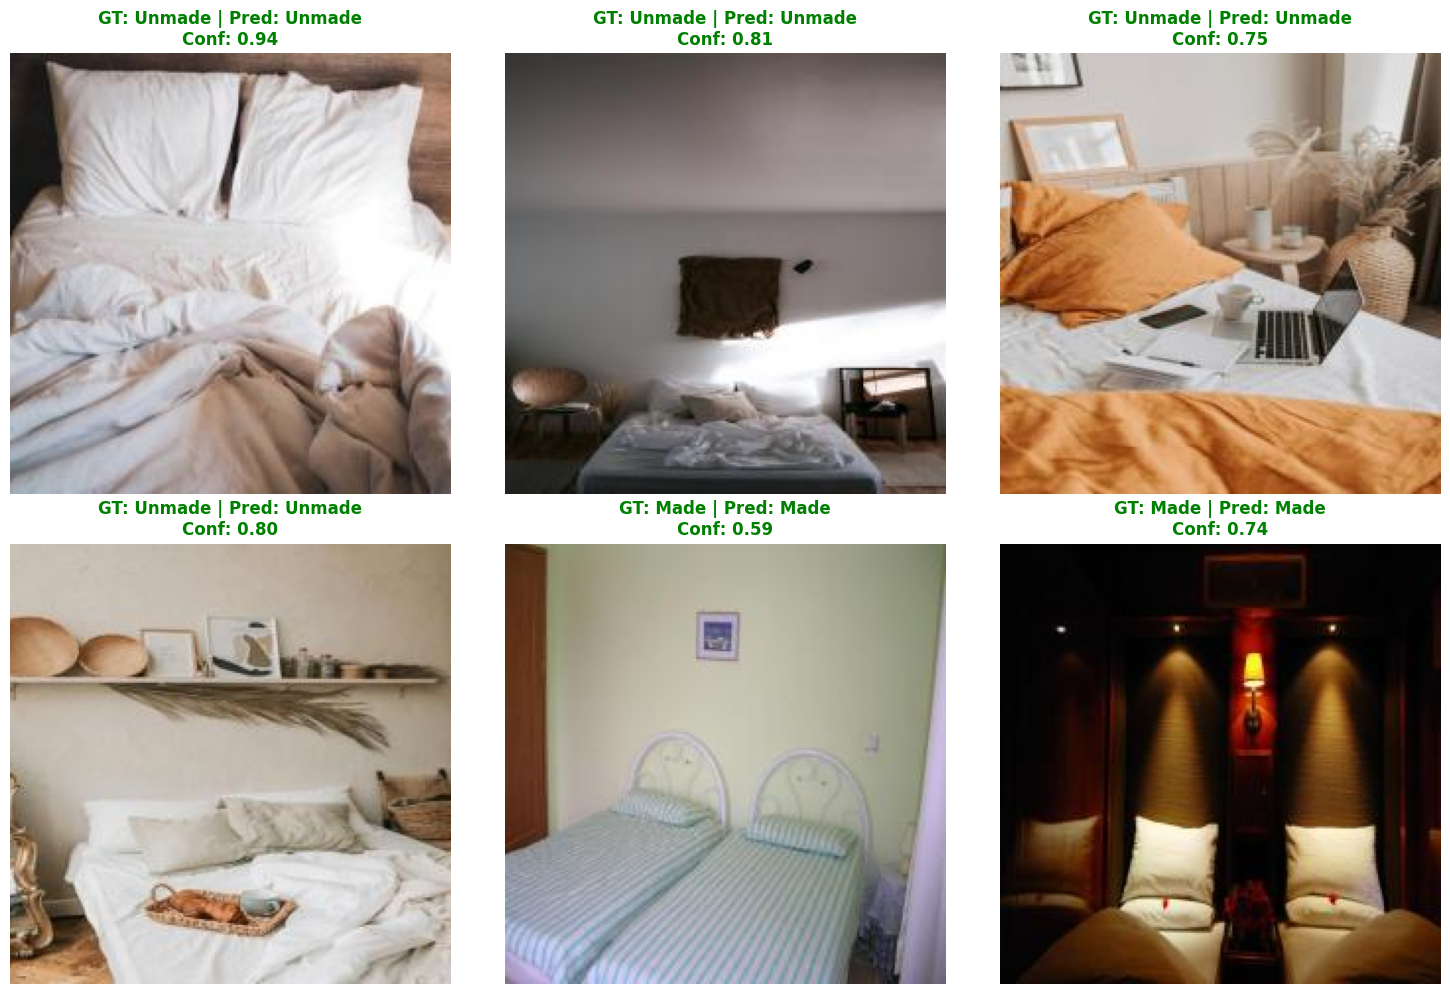

In [ ]:
# CELL 23: Visualize Sample Predictions
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random


DATA_ROOT = "/content/drive/MyDrive/Unmade"
VAL_CSV = f"{DATA_ROOT}/val.csv"
PRED_CSV = "/content/drive/MyDrive/projects/submissions/stage1_val.csv"
SAVE_PATH = "/content/drive/MyDrive/projects/sample_predictions.png"

pred_df = pd.read_csv(PRED_CSV)
val_df = pd.read_csv(VAL_CSV)

sample_preds = pred_df.sample(n=min(6, len(pred_df)), random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

label_names = {0: 'Made', 1: 'Unmade'}

for idx, (_, row) in enumerate(sample_preds.iterrows()):
    img_path = f"{DATA_ROOT}/images/val/{row['image_id']}"
    img = Image.open(img_path)

    gt_label = val_df[val_df['image_id'] == row['image_id']]['label'].values[0]
    pred_label = row['pred_label']
    confidence = row.get('confidence', 1.0)  # default to 1.0 if not in CSV

    axes[idx].imshow(img)
    color = 'green' if gt_label == pred_label else 'red'
    title = f"GT: {label_names[gt_label]} | Pred: {label_names[pred_label]}\nConf: {confidence:.2f}"
    axes[idx].set_title(title, color=color, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# CELL 24: Save Results to Google Drive

import shutil
import os

RESULTS_DIR = "/content/drive/MyDrive/stage1_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

shutil.copytree(
    "/content/drive/MyDrive/projects/runs/stage1_binary",
    os.path.join(RESULTS_DIR, "stage1_binary"),
    dirs_exist_ok=True
)


shutil.copy(
    "/content/drive/MyDrive/projects/submissions/stage1_test.csv",
    RESULTS_DIR
)
shutil.copy(
    "/content/drive/MyDrive/projects/submissions/stage1_val.csv",
    RESULTS_DIR
)

shutil.copy(
    "/content/drive/MyDrive/projects/sample_predictions.png",
    RESULTS_DIR
)

print(f"Results saved to: {RESULTS_DIR}")
print("\nFiles saved:")
print("  - best_stage1.pt (trained model inside stage1_binary folder)")
print("  - train_summary.json (training history inside stage1_binary folder)")
print("  - stage1_test.csv (test predictions)")
print("  - stage1_val.csv (validation predictions)")
print("  - sample_predictions.png (visualization)")


Results saved to: /content/drive/MyDrive/stage1_results

Files saved:
  - best_stage1.pt (trained model inside stage1_binary folder)
  - train_summary.json (training history inside stage1_binary folder)
  - stage1_test.csv (test predictions)
  - stage1_val.csv (validation predictions)
  - sample_predictions.png (visualization)
